# Initialisation

In [27]:
#import *
import numpy as np
import os
import nglview as ngl
from ase.io import read, write
from panedr import edr_to_df as edrdf
import matplotlib.pyplot as plt
import pandas as pd
WDIR='/mnt/c/Users/hargu978/Documents/GroPolBul/tutorial/PEO_LiTFSI'
#%mkdir {WDIR}
%cd {WDIR}

#Desired polymer electrolyte system
#%mkdir Tg
%cd Tg

def tg_fit(temp,dens,lt_idx0,lt_idx1,ht_idx0,ht_idx1,lbl='',color='tab:blue',mkr='o'):
    #Defing the low and high temperature ranges with index
    high_t=temp[((temp >= ht_idx0)) & ((temp <= ht_idx1))];high_d=dens[((temp >= ht_idx0)) & ((temp <= ht_idx1))]
    low_t=temp[((temp >= lt_idx0)) & ((temp <= lt_idx1))];low_d=dens[((temp >= lt_idx0)) & ((temp <= lt_idx1))]
    m_high, c_high = np.polyfit(list(high_t), list(high_d), 1);m_low, c_low = np.polyfit(list(low_t), list(low_d), 1)
    tg_cal=(c_low-c_high)/(m_high-m_low)
    den_tg=m_low*tg_cal+c_low
    plt.plot(temp,[m_high*tk+c_high for tk in temp],ls='-.',c='red',alpha=0.5,lw=1);plt.plot(temp,[m_low*tk+c_low for tk in temp],ls='-.',c='blue',alpha=0.5,lw=1)
    plt.scatter(tg_cal,den_tg,marker='X',c='k')
    plt.plot(temp,dens,label=lbl+' '+str(np.round(tg_cal,2)),ls='--',lw=1,color=color,marker=mkr)
    plt.xlabel('T [K]');plt.ylabel(r'$\rho$ [kg.m$^{-3}$]');plt.legend()
    return('Tg_'+lbl,tg_cal)


/mnt/c/Users/hargu978/Documents/GroPolBul/tutorial/PEO_LiTFSI
/mnt/c/Users/hargu978/Documents/GroPolBul/tutorial/PEO_LiTFSI/Tg


/mnt/c/Users/hargu978/Documents/miniconda3/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Annealing simulation 

In [14]:
%rm \#* core
conc=0
#Initial NPT
npt_mdp=open('npt_tg.mdp','w+')
npt_mdp.write('''title                   =  NPT equilibration 

; Run parameters
integrator              = md        ; leap-frog integrator
nsteps                  = 23000000     ; 0.001 * 200000000 = 20 ns
;nsteps                  = 84000000     ; 0.001 * 84000000 = 84 ns
dt                      = 0.001     ; 1 fs
; Output control
nstxout                 = 0       ; suppress bulky .trr filesave coordinates every 0 ps
nstvout                 = 0       ; save velocities every 1.0 ps
nstenergy               = 1000       ; save energies every 0.1 ps
nstlog                  = 1000       ; update log file every 0.1 ps
nstxout-compressed      = 1000000      ; save compressed coordinates every 1.0 ps
compressed-x-grps       = System    ; save the whole system

continuation            = no       ; Restarting after NVT 
constraint_algorithm    = lincs     ; holonomic constraints 
constraints             = h-bonds   ; bonds involving H are constrained
lincs_iter              = 1         ; accuracy of LINCS
lincs_order             = 4         ; also related to accuracy
; Nonbonded settings 
cutoff-scheme           = Verlet    ; Buffered neighbor searching
ns_type                 = grid      ; search neighboring grid cells
nstlist                 = 10        ; 10 fs, largely irrelevant with Verlet scheme
rcoulomb                = 1.2       ; short-range electrostatic cutoff (in nm)
rvdw                    = 1.2       ; short-range van der Waals cutoff (in nm)
DispCorr                = EnerPres  ; account for cut-off vdW scheme
; Electrostatics
coulombtype             = PME       ; Particle Mesh Ewald for long-range electrostatics
pme_order               = 4         ; cubic interpolation
fourierspacing          = 0.4      ; grid spacing for FFT
; Temperature coupling is on
tcoupl                  = V-rescale             ; modified Berendsen thermostat
tc-grps                 = System       ; two coupling groups - more accurate
tau_t                   = 1.0     ; time constant, in ps
ref_t                   = 540    ; reference temperature, one for each group, in K
; Simulated annealing
annealing               = single
annealing_npoints        = 42
annealing_time          = 0 1000 1010 2010 2020 3020 3030 4030 4040 5040 5050 6050 6060 7060 7070 8070 8080 9080 9090 10090 10100 11100 11110 12110 12120 13120 13130 14130 14140 15140 15150 16150 16160 17160 17170 18170 18180 19180 19190 21190 22000 23000
;annealing_time          = 0 4000 5000 8000 9000 12000 13000 16000 17000 20000 21000 24000 25000 28000 29000 32000 33000 36000 37000 40000 41000 44000 45000 48000 49000 52000 53000 56000 57000 60000 61000 64000 65000 68000 69000 72000 73000 76000 77000 80000 81000 84000 
annealing_temp          = 540 540 520 520 500 500 480 480 460 460 440 440 420 420 400 400 380 380 360 360 340 340 320 320 300 300 280 280 260 260 240 240 220 220 200 200 180 180 160 160 140 140
; Pressure coupling is on
pcoupl                  = Berendsen     ; Pressure coupling on in NPT
pcoupltype              = isotropic             ; uniform scaling of box vectors
tau_p                   = 1.0                   ; time constant, in ps
ref_p                   = 1.0                   ; reference pressure, in bar
compressibility         = 4.5e-5                ; isothermal compressibility of water, bar^-1
; Periodic boundary conditions
pbc                     = xyz       ; 3-D PBC
; Velocity generation
gen_vel                 = no        ; Velocity generation is off 

''')
npt_mdp.close()

!gmx grompp -f npt_tg.mdp -c ../preeq/npt_{conc}.gro -p ../topol_{conc}.top -o npt_{conc}.tpr -maxwarn 2
#!gmx mdrun -s npt_{conc}.tpr -cpi npt_{conc}.cpt -deffnm npt_{conc} # -v


rm: cannot remove 'core': No such file or directory
                      :-) GROMACS - gmx grompp, 2023.3 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /mnt/c/Users/hargu978/Documents/GroPolBul/tutorial/PEO_LiTFSI/Tg
Command line:
  gmx grompp -f npt_tg.mdp -c ../preeq/npt_0.gro -p ../topol_0.top -o npt_0.tpr -maxwarn 2

Ignoring obsolete mdp entry 'title'
Ignoring obsolete mdp entry 'ns_type'

WARNING 1 [file npt_tg.mdp]:
  The Berendsen barostat does not generate any strictly correct ensemble,
  and should not be used for new production simulations (in our opinion).
  We recommend using the C-rescale barostat instead.

Setting the LD random seed to -1083322946

Generated 210 of the 210 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 210 of the 210 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'PEO'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule

# Temperature vs density plots

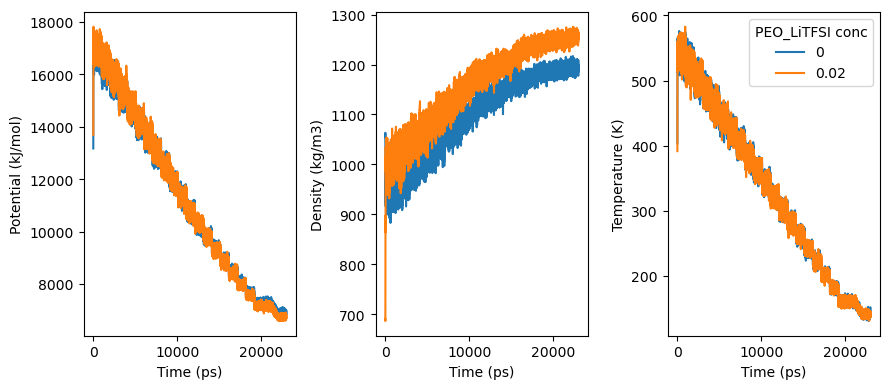

In [36]:
plt.figure(figsize=(3*3,4))
for conc in [0,0.02]:
    df=edrdf('npt_'+str(conc)+'.edr')
    plt.subplot(1,3,1)
    plt.plot(df['Time'],df['Potential'],label=str(conc))
    plt.xlabel('Time (ps)');plt.ylabel('Potential (kJ/mol)');
    plt.subplot(1,3,2)
    plt.plot(df['Time'],df['Density'],label=str(conc))
    plt.xlabel('Time (ps)');plt.ylabel('Density (kg/m3)');
    plt.subplot(1,3,3)
    plt.plot(df['Time'],df['Temperature'],label=str(conc))
    plt.xlabel('Time (ps)');plt.ylabel('Temperature (K)');
    plt.legend(title='PEO_LiTFSI conc')

plt.tight_layout()

In [39]:
#0 1000 1010 2010 2020 3020 3030 4030 4040 5040 5050 6050 6060 7060 7070 8070 8080 9080 9090 10090 10100 11100 11110 12110 12120 13120 13130 14130 14140 15140 15150 16150 16160 17160 17170 18170 18180 19180 19190 21190 22000 23000
tg_data={}
for conc in [0,0.02]:
    df=edrdf('npt_'+str(conc)+'.edr')
    tg_data[conc]=pd.DataFrame(columns=['T_K','den_mean','den_std'])
    for i,ti in enumerate(range(500,20*1000+1,1010)):
        tg_data[conc].at[i,'T_K']=np.round(df.iloc[int(ti):int((ti+500))]['Temperature'].mean())
        tg_data[conc].at[i,'den_mean']=float(df.iloc[int(ti):int((ti+500))]['Density'].mean())
        tg_data[conc].at[i,'den_std']=float(df.iloc[int(ti):int((ti+500))]['Density'].std())

    i=i+1
    ti=22*1000+1
    tg_data[conc].at[i,'T_K']=np.round(df.iloc[int(ti):int((ti+500))]['Temperature'].mean())
    tg_data[conc].at[i,'den_mean']=float(df.iloc[int(ti):int((ti+500))]['Density'].mean())
    tg_data[conc].at[i,'den_std']=float(df.iloc[int(ti):int((ti+500))]['Density'].std())

        #print(ti,ti+400)
tg_data[conc]

,T_K,den_mean,den_std
0,541.0,1002.886348,18.291044
1,521.0,1017.681612,20.231559
2,502.0,1034.160836,17.00425
3,482.0,1046.999352,17.704663
4,461.0,1065.464905,16.043741
5,441.0,1082.724133,14.992311
6,421.0,1103.354069,15.788609
7,401.0,1118.746648,13.951914
8,381.0,1140.610429,13.708337
9,361.0,1157.446798,12.10461


# Tg calculation

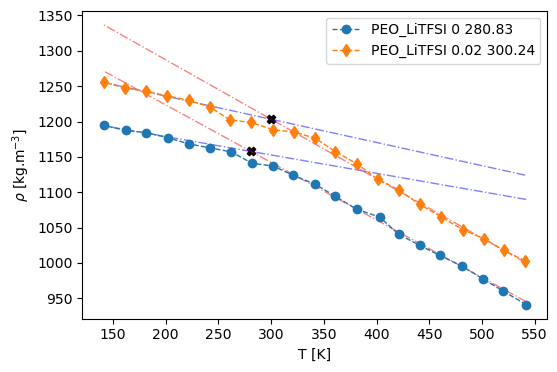

In [50]:
plt.figure(figsize=(6,4))
for conc,cl,mk in zip([0,0.02],['tab:blue','tab:orange'],['o','d']):
    tg_fit(tg_data[conc]['T_K'],tg_data[conc]['den_mean'],140,200,300,500,'PEO_LiTFSI '+str(conc),cl,mk)